In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [30]:
data_path = r"C:\Users\LENOVO\Desktop\Python\Datasets\Oil Prediction\train.csv"

df = pd.read_csv(data_path, parse_dates=['date'])
df = df[(df['store_nbr'] == 1) & (df['family'] == 'GROCERY I')]
df = df.sort_values('date')

sales = df['sales'].values.reshape(-1, 1)

In [32]:
# Feature engineering
df['onpromotion'] = df['onpromotion'].fillna(0)
df['dayofweek'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

features = ['sales', 'onpromotion', 'dayofweek', 'month']

In [33]:
scalers = {}
scaled_data = pd.DataFrame()
for feature in features:
    scaler = MinMaxScaler()
    scaled_data[feature] = scaler.fit_transform(df[[feature]]).flatten()
    scalers[feature] = scaler

In [34]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(data.iloc[i+seq_length]['sales'])
    return np.array(X), np.array(y)

sequence_length = 30
X, y = create_sequences(scaled_data, sequence_length)

In [35]:
X = X.reshape((X.shape[0], X.shape[1], len(features)))

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [47]:
# Build RNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(sequence_length, len(features))),
    tf.keras.layers.SimpleRNN(58, activation='relu', return_sequences=True),
    tf.keras.layers.SimpleRNN(75, activation='relu'),
    tf.keras.layers.Dense(98, activation='relu'),
    tf.keras.layers.Dropout(0.28034071587366755),
    tf.keras.layers.Dense(55, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(3e-4), 
              loss='mse',
              metrics=['mae'])

Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_116 (SimpleRNN)      │ (None, 30, 58)         │         3,654 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_117 (SimpleRNN)      │ (None, 75)             │        10,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 98)             │         7,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 98)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_217 (Dense)               │ (None, 55)             │         5,445 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 1)              │            56 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,653 (104.11 KB)

 Trainable params: 26,653 (104.11 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model.fit(X_train, 
          y_train,
          validation_data=(X_test, y_test), 
          epochs=20, 
          batch_size=32)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1304 - mae: 0.2714 - val_loss: 0.0124 - val_mae: 0.0893
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0123 - mae: 0.0838 - val_loss: 0.0095 - val_mae: 0.0762
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - mae: 0.0708 - val_loss: 0.0073 - val_mae: 0.0654
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0073 - mae: 0.0592 - val_loss: 0.0062 - val_mae: 0.0585
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - mae: 0.0518 - val_loss: 0.0058 - val_mae: 0.0558
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - mae: 0.0510 - val_loss: 0.0055 - val_mae: 0.0541
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mae: 0.0463 - val_loss: 0.0047 - val_mae: 0.0472
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - mae: 0.0460 - val_loss: 0.0047 - val_mae: 0.0481
Epoch 9/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047 - mae:

In [49]:
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


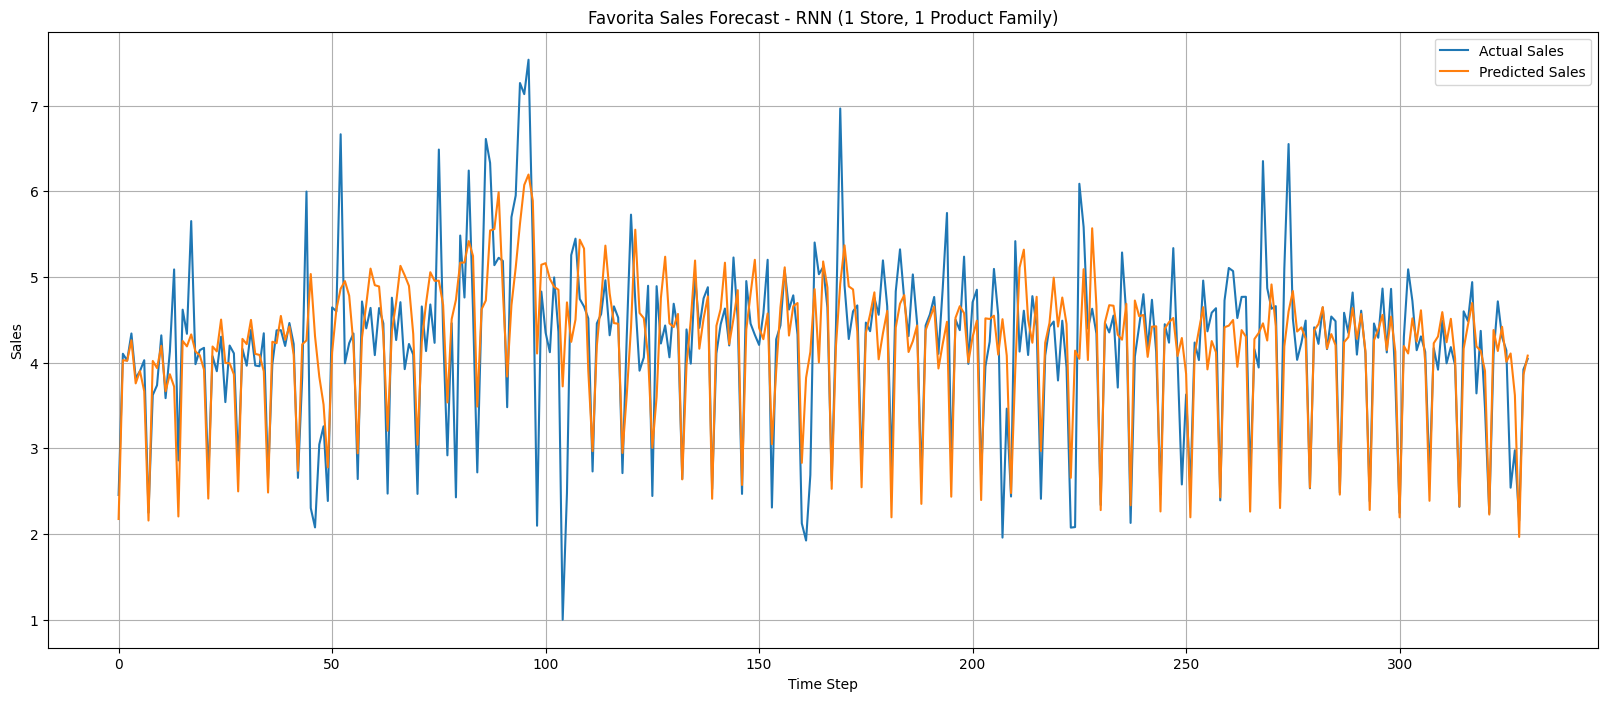

In [50]:
plt.figure(figsize=(20, 8))
plt.plot(actual, label='Actual Sales')
plt.plot(predicted, label='Predicted Sales')
plt.title('Favorita Sales Forecast - RNN (1 Store, 1 Product Family)')
plt.xlabel('Time Step')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# **Model Description**

### **Architecture Details**
- **Input shape**: `(30, 4)`
Represents a sliding window of the past 30 days, with 4 input features:

- **Layer 1**: `SimpleRNN (58 units, ReLU, return_sequences=True)`
Captures short- and mid-term dependencies across the 30-day time window.

- **Layer 2**: `SimpleRNN (75 units, ReLU)`
Learns deeper temporal patterns by aggregating the output of the first RNN layer.

- **Layer 3**: `Dense (98 units, ReLU)`
Projects the RNN output into a higher-dimensional feature space for richer representation.

- **Layer 4**: `Dropout (rate = 0.2803)`
Regularizes the network to prevent overfitting by randomly deactivating ~28% of the dense layer neurons during training.

- **Layer 5**: `Dense (55 units, ReLU)`
Further refines the learned features before final output.

- **Output Layer**: `Dense (1 unit)`
Predicts the next-day sales (normalized).

### **2. Training Configuration**
- **Loss Function**: Mean Squared Error (MSE)

- **Optimizer**: `Adam (learning rate = 3e-4)`

- **Batch Size**: `32`

- **Epochs**: `20`

Validation: Performance evaluated on a hold-out test set.

# **Code Description**

### **1. Data Loading and Filtering**
Load the train.csv file and parse the date column as datetime.

Filter the dataset to include only:

store_nbr == 1

family == "GROCERY I"

Sort the data by date to preserve temporal ordering.

### ** 2. Feature Engineering**
Fill missing values in the onpromotion column with 0.

Extract calendar features:

dayofweek: Day of the week (0=Monday, 6=Sunday)

month: Month number (1–12)

### ** 3. Feature Scaling**
Selected features for modeling:

sales

onpromotion

dayofweek

month

Each feature is scaled individually using MinMaxScaler to normalize values between 0 and 1.

###  **4. Sequence Creation**
A sliding window of 30 days (sequence_length = 30) is used to generate training samples.

For each 30-day window of multivariate data, the model is trained to predict the sales value of the next day.

###  **5. Data Preparation**
Input shape: (samples, 30, 4) where 4 is the number of features.

Train/test split: 80% for training, 20% for testing.

###  **6. Model Architecture**
A deep Recurrent Neural Network (RNN) is used:

Input shape: (30 timesteps, 4 features)

<pre>
    Layer Type           Units                 Activation                  Description

🔹 SimpleRNN             58                   ReLU                        First RNN layer, returns sequences

🔹 SimpleRNN             75                   ReLU                        Second RNN layer

🔹 Dense                 98                   ReLU                        Fully connected layer

🔹 Dropout              0.28                  -                           Prevents overfitting

🔹 Dense                 55                   ReLU                        Fully connected layer

🔹 Output (Dense)         1                   Linear                      Predicts next day's sales

</pre>

###  **7. Compilation and Training**
Optimizer: Adam (learning rate = 3e-4)

Loss Function: Mean Squared Error (MSE)

Metrics: Mean Absolute Error (MAE)

Training: 20 epochs, batch size of 32

Validation: Evaluated on the test split

###  **8. Predictions and Evaluation**
Predictions and actual sales values are inverse transformed back to original scale.

Sales predictions are visualized against actual values using Matplotlib.

# **My Comments**

- Replacing the RNN with LSTM's or GRU's could significantly increase the performance.
- Correct data dimensions are very important while working with Time Series